# Exercise 4: recommender System

In [1]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [2]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [3]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [4]:
def getTopN(movie_id,D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

Have a llok at the pdist documentation to see all implemented distance measures: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

In [5]:
#cosine distance from lecture
import scipy.spatial
D_cos=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D_cos=np.abs(np.nan_to_num( D_cos-1)) #dist to similarity 
np.fill_diagonal(D_cos,0) #set self-dist to zero

In [30]:
#euclidean (L2) 
D_L2=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
D_L2=np.abs(np.nan_to_num( D_L2-np.max(D_L2))) #dist to similarity 
np.fill_diagonal(D_L2,0) #set self-dist to zero

In [31]:
#correlation 
D_cor=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='correlation'))
D_cor=np.abs(np.nan_to_num( D_cor-1)) #dist to similarity 
np.fill_diagonal(D_cor,0) #set self-dist to zero

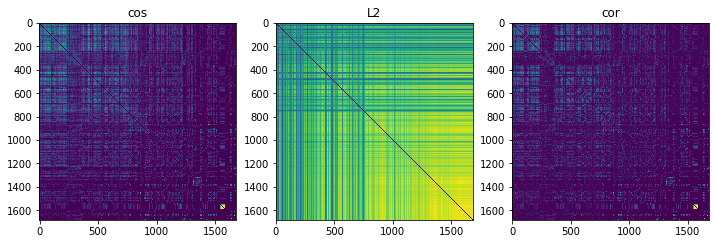

In [32]:
#plot all D
import matplotlib.pyplot as plt

w=20
h=20
fig=plt.figure(figsize=(12, 12))
ax1=fig.add_subplot(1, 3, 1)
ax1.title.set_text('cos')
plt.imshow(D_cos)
ax2= fig.add_subplot(1, 3, 2)
ax2.title.set_text('L2')
plt.imshow(D_L2)
ax3=fig.add_subplot(1, 3, 3)
ax3.title.set_text('cor')
plt.imshow(D_cor)
plt.show()

### Helper function: compare two distance matrices
We use a split into train and test (like in the lecture)


In [33]:
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)

#re-train D on train data
D_cos=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
D_cos=np.abs(np.nan_to_num( D_cos-1)) #dist to similarity 
np.fill_diagonal(D_cos,0) #set self-dist to zero

D_L2=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='euclidean'))
D_L2=np.abs(np.nan_to_num( D_L2-1)) #dist to similarity 
np.fill_diagonal(D_L2,0) #set self-dist to zero

D_cor=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='correlation'))
D_cor=np.abs(np.nan_to_num( D_cor-1)) #dist to similarity 
np.fill_diagonal(D_cor,0) #set self-dist to zero

we can re-use the scoring function from the lecture (defined in the exercise)  

In [34]:
test_cos=test_Score(D_cos,R_test)
test_L2=test_Score(D_L2,R_test)
test_cor=test_Score(D_cor,R_test)

In [35]:
print("Mean scores on test: cos:",np.mean(test_cos), "L2:",np.mean(test_L2), "cor:",np.mean(test_cor))

Mean scores on test: cos: 2.122947368421053 L2: 1.425263157894737 cor: 1.8029473684210529


In [36]:
print("Median scores on test: cos:",np.median(test_cos), "L2:",np.median(test_L2), "cor:",np.median(test_cor))

Median scores on test: cos: 2.2399999999999998 L2: 1.3199999999999998 cor: 1.8399999999999999


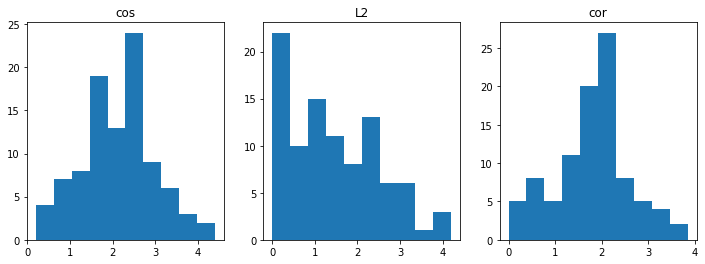

In [37]:
fig=plt.figure(figsize=(12, 4))
ax1=fig.add_subplot(1, 3, 1)
ax1.title.set_text('cos')
plt.hist(test_cos)
ax2= fig.add_subplot(1, 3, 2)
ax2.title.set_text('L2')
plt.hist(test_L2)
ax3=fig.add_subplot(1, 3, 3)
ax3.title.set_text('cor')
plt.hist(test_cor)
plt.show()




-> L2 is clearly worse than cos and cor

## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [38]:
# helper functions for the baseline recommendations
def getRandomMovies(ID, D, n=5):
    return np.random.randint(np.shape(D)[0], size=n) #return random vector of size n with values 0 to number of items

def getTopMoviewFromAll(ID, D):
    t = np.sum(D,axis=0)
    return np.argsort(t)[-5:]

# re implement  eval functions to allow different rankings
def Score_byID(ID, D, Test, f): #f ist the ranking function
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = f(ID,D)[::-1]
    res_title = getNameByID(f(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test,f=getTopN): #f ist the ranking function -> function as argument
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i],f)
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [39]:
#run our tests
test_randx=test_Score(D_cos,R_test,getRandomMovies)
test_top=test_Score(D_cos,R_test,getTopMoviewFromAll)

In [40]:
print("Mean scores on test: cos:",np.mean(test_cos), "random:",np.mean(test_randx), "Top5:",np.mean(test_top))

Mean scores on test: cos: 2.122947368421053 random: 0.2050526315789474 Top5: 1.576842105263158


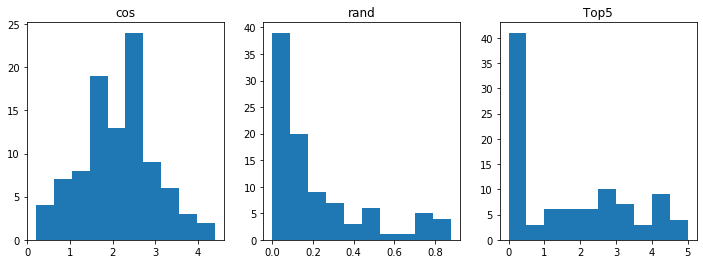

In [41]:
fig=plt.figure(figsize=(12, 4))
ax1=fig.add_subplot(1, 3, 1)
ax1.title.set_text('cos')
plt.hist(test_cos)
ax2= fig.add_subplot(1, 3, 2)
ax2.title.set_text('rand')
plt.hist(test_randx)
ax3=fig.add_subplot(1, 3, 3)
ax3.title.set_text('Top5')
plt.hist(test_top)
plt.show()

## 4.3 SVD
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$

In [42]:
#compute SVD
U,S,V=np.linalg.svd(R_train)

In [43]:
#have a look at the matrix shapes
print(np.shape(R_train),np.shape(U),np.shape(S),np.shape(V))

(848, 1682) (848, 848) (848,) (1682, 1682)


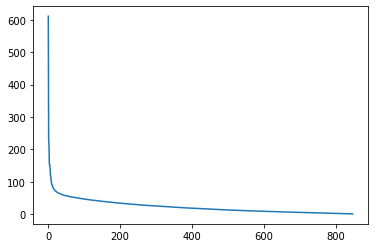

In [44]:
# S is stored diagonal matrix (vector of diagonal elements of S)
# plot singular values
plt.plot(S)


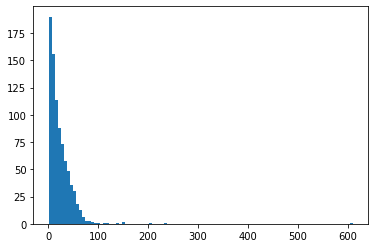

In [45]:
#see how many small (close to zero) sigular values we have
t=plt.hist(S,bins=100)

In [46]:
#check if reconstruction is close to original
# CAUTION: recall, that U and V are square matrices of different sizes
# -> need to cut off both to have same size
np.allclose(R_train, np.dot(U * S, V[:848,:])) 

True

In [47]:
# now reconstruct with loss
cut = 10 #select how many dims we want to keep
R_approx = np.dot(U[:,:cut] * S[:cut], V[:cut,:])

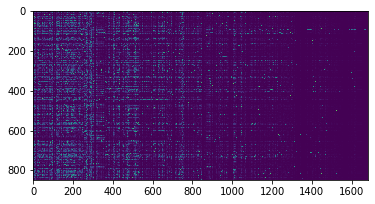

In [48]:
# show differnence
plt.imshow(np.abs(R_train-R_approx))

In [49]:
#compute D from R and R_approx
# NOTE: in practice, we would not do this (becase D is as large as before) and would compute the distance when needed. Now we compute a full D for simplicity (we cann use the same tools as before)
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

D_approx=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_approx.T, metric='cosine'))
D_approx=np.abs(np.nan_to_num( D_approx-1)) #dist to similarity 
np.fill_diagonal(D_approx,0) #set self-dist to zero


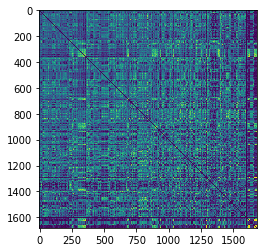

In [50]:
# show differnence
plt.imshow(np.abs(D-D_approx))

In [51]:
#run our tests
test_approx=test_Score(D_approx,R_test)

In [52]:
print("Mean scores on test: full cos:",np.mean(test_cos), "approx cos:",np.mean(test_approx))

Mean scores on test: full cos: 2.122947368421053 approx cos: 1.649263157894737


(array([ 5.,  8., 17., 18., 17., 14.,  5.,  3.,  4.,  4.]),
 array([0.2 , 0.54, 0.88, 1.22, 1.56, 1.9 , 2.24, 2.58, 2.92, 3.26, 3.6 ]),
 <a list of 10 Patch objects>)

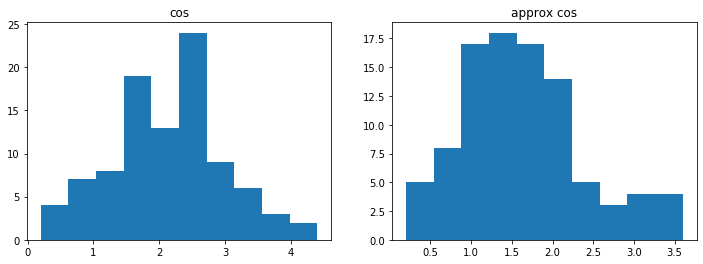

In [53]:
fig=plt.figure(figsize=(12, 4))
ax1=fig.add_subplot(1, 2, 1)
ax1.title.set_text('cos')
plt.hist(test_cos)
ax2= fig.add_subplot(1, 2, 2)
ax2.title.set_text('approx cos')
plt.hist(test_approx)